# Optimization

In this notebook, we explore various optimization problems and algorithms.

## TOC
* [Automatic differentiation](#AD)
* [Stochastic gradient descent](#SGD)

In [1]:

import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial

import os
figdir = "../figures" # set this to '' if you don't want to save figures
def save_fig(fname):
    if figdir:
        plt.savefig(os.path.join(figdir, fname))

import numpy as onp
onp.set_printoptions(precision=3)
import jax
import jax.numpy as np
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
from jax.experimental import optimizers
print("jax version {}".format(jax.__version__))
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

import torch
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print("current device {}".format(torch.cuda.current_device()))
else:
    print("Torch cannot find GPU")
    
import tensorflow as tf
from tensorflow import keras
print("tf version {}".format(tf.__version__))
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("TF cannot find GPU")



jax version 0.1.39
jax backend cpu
torch version 1.1.0
Torch cannot find GPU
tf version 2.0.0-dev20190629
TF cannot find GPU


## Automatic differentiation <a class="anchor" id="AD"></a>

In this section we  illustrate various AD libraries.

### AD in JAX  <a class="anchor" id="AD-jax"></a>

For some examples of using JAX to compute the gradients, Jacobians and Hessians of simple linear and quadratic functions,
see [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/linear_algebra.ipynb#AD-jax).
For an example of using JAX to compute the gradient of the NLL for binary logistic regression,
see [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/linear_algebra.ipynb#AD-jax-log).

More details on JAX's autodiff can be found in the official [autodiff cookbook](https://github.com/google/jax/blob/master/notebooks/autodiff_cookbook.ipynb).


### AD in TF  <a class="anchor" id="AD-TF"></a>

Unfinished.

### AD in PyTorch  <a class="anchor" id="AD-pytorch"></a>

Unfinished.

## Stochastic gradient descent <a class="anchor" id="SGD"></a>

In this section we  illustrate how to implement SGD.

### SGD in Jax <a class="anchor" id="SGD-jax"></a>

JAX has a minimal optimization library focused on stochastic first-order optimizers. Every optimizer is modeled as an (`init_fun`, `update_fun`, `get_params`) triple of functions. The `init_fun` is used to initialize the optimizer state, which could include things like momentum variables, and the `update_fun` accepts a gradient and an optimizer state to produce a new optimizer state. The `get_params` function extracts the current iterate (i.e. the current parameters) from the optimizer state. The parameters being optimized can be ndarrays or arbitrarily-nested list/tuple/dict structures, so you can store your parameters however you’d like.

We give some examples below.

### SGD for logistic regression <a class="anchor" id="SGD-logreg-jax"></a>

We consider a convex problem, namely MLE for binary logistic regression,
where we compute the exact optimum. We solve this using a batch solver (BFGS) to create the gold standard.
We use Jax for the gradient computations (see  [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/linear_algebra.ipynb#AD-jax-logreg) for details). Later we also use Jax's optimization library. 

In [2]:
# First we create a dataset.

import sklearn.datasets
from sklearn.model_selection import train_test_split

iris = sklearn.datasets.load_iris()
X = iris["data"][:,:3] # Just take first 3 features to make problem harder
y = (iris["target"] == 2).astype(onp.int)  # 1 if Iris-Virginica, else 0'
N, D = X.shape # 150, 4


X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)


In [3]:
# Now let's find the MLE using sklearn. We will use this as the "gold standard"

from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
# We don't fit the bias term to simplify the comparison below.
log_reg = LogisticRegression(solver="lbfgs", C=1e5, fit_intercept=False)
log_reg.fit(X_train, y_train)
w_mle_sklearn = np.ravel(log_reg.coef_)
print(w_mle_sklearn)


[-5.457 -4.877  9.756]


In [4]:
# Now we try to fit the model ourselves by defining a suitable objective.

def sigmoid(x): return 0.5 * (np.tanh(x / 2.) + 1)

def predict_logit(weights, inputs):
    return np.dot(inputs, weights) # Already vectorized

def predict_prob(weights, inputs):
    return sigmoid(predict_logit(weights, inputs))

from jax.scipy.special import logsumexp
#from scipy.misc import logsumexp

def NLL(weights, batch):
    # Use log-sum-exp trick
    inputs, targets = batch
    # p1 = 1/(1+exp(-logit)), p0 = 1/(1+exp(+logit))
    logits = predict_logit(weights, inputs).reshape((-1,1))
    N = logits.shape[0]
    logits_plus = np.hstack([np.zeros((N,1)), logits]) # e^0=1
    logits_minus = np.hstack([np.zeros((N,1)), -logits])
    logp1 = -logsumexp(logits_minus, axis=1)
    logp0 = -logsumexp(logits_plus, axis=1)
    logprobs = logp1 * targets + logp0 * (1-targets)
    return -np.sum(logprobs)/N



In [92]:
# Define a test function for comparing solvers

def evaluate_params(w_opt, w_est, name):
    print("parameters from optimal\n{}".format(w_opt))
    print("parameters from {}\n{}".format(name, w_est))
    print("max delta: {}".format(np.max(np.abs(w_opt - w_est))))
    
def evaluate_preds(w_opt, w_est, name):
    p_opt = predict_prob(w_opt, X_test)
    p_est = predict_prob(w_est, X_test)
    print("predictions from optimal\n{}".format(np.round(p_opt, 3)))
    print("predictions from {}\n{}".format(name, np.round(p_est, 3)))
    print("max delta: {}".format(np.max(np.abs(p_opt - p_est))))

In [11]:
# Batch solver.

import scipy.optimize

def training_loss(w):
    return NLL(w, (X_train, y_train))

def training_grad(w):
    return grad(training_loss)(w)

onp.random.seed(43)
w_init = onp.random.randn(D)
w_mle_scipy = scipy.optimize.minimize(training_loss, w_init, jac=training_grad, method='BFGS').x


In [10]:
evaluate_params(w_mle_sklearn, w_mle_scipy, "scipy")
evaluate_preds(w_mle_sklearn, w_mle_scipy, "scipy")


parameters from optimal
[-5.457 -4.877  9.756]
parameters from scipy
[-5.457 -4.878  9.757]
max delta: 0.0014805528335273266
predictions from optimal
[0.251 0.    1.    0.048 0.019 0.    0.    0.047 0.34  0.001 0.21  0.
 0.    0.    0.    0.01  0.998 0.009 0.297 0.998 0.    0.471 0.    0.998
 0.689 0.386 1.    0.992 0.    0.    0.    0.    0.    0.    0.    0.901
 0.001 0.    0.    0.    0.993 0.004 0.003 0.    0.    0.004 0.848 0.974
 0.    0.935]
predictions from scipy
[0.251 0.    1.    0.048 0.019 0.    0.    0.047 0.341 0.001 0.21  0.
 0.    0.    0.    0.01  0.998 0.009 0.297 0.998 0.    0.471 0.    0.998
 0.689 0.386 1.    0.992 0.    0.    0.    0.    0.    0.    0.    0.901
 0.001 0.    0.    0.    0.993 0.004 0.003 0.    0.    0.004 0.848 0.974
 0.    0.935]
max delta: 3.3289194107055664e-05


In [61]:


class MyBatcher():
    def __init__(self, X, y, batch_size, seed):
        self.num_data = X.shape[0]
        num_complete_batches, leftover = divmod(self.num_data, batch_size)
        self.num_batches = num_complete_batches + bool(leftover)
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.seed = seed
        self.batch_stream = self.make_data_stream()
                
    def make_data_stream(self):
        rng = onp.random.RandomState(self.seed)
        while True:
            perm = rng.permutation(self.num_data)
            for i in range(self.num_batches):
                batch_idx = perm[i * self.batch_size:(i + 1) * self.batch_size]
                yield self.X[batch_idx], self.y[batch_idx]

batcher = MyBatcher(X_train, y_train, batch_size=3, seed=0)
nbatches = 3
for i in range(nbatches):
    batch = next(batcher.batch_stream)
    x, y = batch
    print(x)

[[6.2 3.4 5.4]
 [7.4 2.8 6.1]]
[[5.6 3.  4.5]
 [4.6 3.4 1.4]]
[[5.6 3.  4.1]
 [5.9 3.  5.1]]


In [75]:
# Bare bones SGD

import itertools
import time

def sgd_v1(params, loss_fn, batcher, num_epochs, lr):
    itercount = itertools.count()
    loss_history = []
    for epoch in range(num_epochs):
        start_time = time.time()
        for step in range(batcher.num_batches):
            total_steps = next(itercount)
            batch = next(batcher.batch_stream)
            batch_loss = loss_fn(params, batch)
            batch_grad = grad(loss_fn)(params, batch)
            params = params - lr*batch_grad
        epoch_time = time.time() - start_time
        train_loss = onp.float(loss_fn(params, (batcher.X, batcher.y)))
        loss_history.append(train_loss)
        if True: #epoch % 500 == 0:
            print('Epoch {}, train NLL {}'.format(epoch, train_loss))
    return params, loss_history
                 

In [79]:
onp.random.seed(43)
D = X_train.shape[1]
w_init = onp.random.randn(D)

batcher = MyBatcher(X_train, y_train, batch_size=10, seed=0)
max_epochs = 5
lr = 0.1
w_mle_sgd1, history = sgd_v1(w_init, NLL, batcher, num_epochs=max_epochs, lr=lr)
print(w_mle_sgd1)
print(history)


Epoch 0, train NLL 0.8947761654853821
Epoch 1, train NLL 0.4824911952018738
Epoch 2, train NLL 0.4509454667568207
Epoch 3, train NLL 0.4528477191925049
Epoch 4, train NLL 0.8981762528419495
[ 0.28  -1.151  0.869]
[0.8947761654853821, 0.4824911952018738, 0.4509454667568207, 0.4528477191925049, 0.8981762528419495]


In [106]:
# Version that uses JAX optimization library

@jit
def sgd_jax(params, loss_fn, batcher, max_epochs, opt_init, opt_update, get_params):
    itercount = itertools.count()
    loss_history = []
    opt_state = opt_init(params)
    
    @jit
    def update(i, opt_state, batch):
        params = get_params(opt_state)
        g = grad(loss_fn)(params, batch)
        return opt_update(i, g, opt_state) 
    
    print_every = max(1, int(0.1*max_epochs))
    for epoch in range(max_epochs):
        start_time = time.time()
        for step in range(batcher.num_batches):
            total_steps = next(itercount)
            batch = next(batcher.batch_stream)
            opt_state = update(total_steps, opt_state, batch)
        epoch_time = time.time() - start_time
        params = get_params(opt_state)
        train_loss = onp.float(loss_fn(params, (batcher.X, batcher.y)))
        loss_history.append(train_loss)
        if epoch % print_every == 0:
            print('Epoch {}, train NLL {}'.format(epoch, train_loss))
    return params, loss_history
                 


In [100]:
# JAX with constant LR should match our minimal version of SGD

schedule = optimizers.constant(step_size=lr)
opt_init, opt_update, get_params = optimizers.sgd(step_size=schedule)

max_epochs = 5
batcher = MyBatcher(X_train, y_train, batch_size=10, seed=0)
w_mle_sgd2, history = sgd_jax(w_init, NLL, batcher, max_epochs, 
                              opt_init, opt_update, get_params)
print(w_mle_sgd2)
print(history)



Epoch 0, train NLL 0.8947761654853821
Epoch 1, train NLL 0.4824911952018738
Epoch 2, train NLL 0.4509454667568207
Epoch 3, train NLL 0.4528477191925049
Epoch 4, train NLL 0.8981762528419495
[ 0.28  -1.151  0.869]
[0.8947761654853821, 0.4824911952018738, 0.4509454667568207, 0.4528477191925049, 0.8981762528419495]


In [85]:
# Now run longer and compare to global opt

schedule = optimizers.constant(step_size=lr)
opt_init, opt_update, get_params = optimizers.sgd(step_size=schedule)
max_epochs = 2000
batcher = MyBatcher(X_train, y_train, batch_size=10, seed=0)
w_mle_sgd3, history = sgd_jax(w_init, NLL, batcher, max_epochs,
                              opt_init, opt_update, get_params)
print(w_mle_sgd3)
#print(history)

evaluate_params(w_mle_sklearn, w_mle_sgd3, "SGD-0.1")
evaluate_preds(w_mle_sklearn, w_mle_sgd3, "SGD-0.1")



Epoch 0, train NLL 0.8947761654853821
Epoch 1, train NLL 0.4824911952018738
Epoch 2, train NLL 0.4509454667568207
Epoch 3, train NLL 0.4528477191925049
Epoch 4, train NLL 0.8981762528419495
Epoch 5, train NLL 0.5361756086349487
Epoch 6, train NLL 0.3979598581790924
Epoch 7, train NLL 0.3691052496433258
Epoch 8, train NLL 0.46815353631973267
Epoch 9, train NLL 0.3966706097126007
Epoch 10, train NLL 0.36759117245674133
Epoch 11, train NLL 0.39221227169036865
Epoch 12, train NLL 0.3439350128173828
Epoch 13, train NLL 0.3351922333240509
Epoch 14, train NLL 0.3376809358596802
Epoch 15, train NLL 0.31386876106262207
Epoch 16, train NLL 0.3150806725025177
Epoch 17, train NLL 0.348689466714859
Epoch 18, train NLL 0.31649914383888245
Epoch 19, train NLL 0.3438558280467987
Epoch 20, train NLL 0.2909436821937561
Epoch 21, train NLL 0.2879621088504791
Epoch 22, train NLL 0.2820524275302887
Epoch 23, train NLL 0.3101750910282135
Epoch 24, train NLL 0.28492245078086853
Epoch 25, train NLL 0.37140855

Epoch 205, train NLL 0.1590842455625534
Epoch 206, train NLL 0.18633180856704712
Epoch 207, train NLL 0.18721412122249603
Epoch 208, train NLL 0.1646568924188614
Epoch 209, train NLL 0.15484680235385895
Epoch 210, train NLL 0.16276364028453827
Epoch 211, train NLL 0.15241259336471558
Epoch 212, train NLL 0.15300457179546356
Epoch 213, train NLL 0.1515686959028244
Epoch 214, train NLL 0.16509757936000824
Epoch 215, train NLL 0.16148896515369415
Epoch 216, train NLL 0.1519506573677063
Epoch 217, train NLL 0.15625137090682983
Epoch 218, train NLL 0.15091173350811005
Epoch 219, train NLL 0.15137307345867157
Epoch 220, train NLL 0.15132762491703033
Epoch 221, train NLL 0.1574711799621582
Epoch 222, train NLL 0.15231293439865112
Epoch 223, train NLL 0.16328200697898865
Epoch 224, train NLL 0.1506117284297943
Epoch 225, train NLL 0.15034520626068115
Epoch 226, train NLL 0.15724167227745056
Epoch 227, train NLL 0.14984656870365143
Epoch 228, train NLL 0.14972393214702606
Epoch 229, train NLL 0

Epoch 408, train NLL 0.16923058032989502
Epoch 409, train NLL 0.13924555480480194
Epoch 410, train NLL 0.1400509476661682
Epoch 411, train NLL 0.14456646144390106
Epoch 412, train NLL 0.13939201831817627
Epoch 413, train NLL 0.14510685205459595
Epoch 414, train NLL 0.15961337089538574
Epoch 415, train NLL 0.1459842026233673
Epoch 416, train NLL 0.17169107496738434
Epoch 417, train NLL 0.14021776616573334
Epoch 418, train NLL 0.1401820331811905
Epoch 419, train NLL 0.13852208852767944
Epoch 420, train NLL 0.150923952460289
Epoch 421, train NLL 0.15743140876293182
Epoch 422, train NLL 0.14411446452140808
Epoch 423, train NLL 0.13942688703536987
Epoch 424, train NLL 0.1423778086900711
Epoch 425, train NLL 0.1515454798936844
Epoch 426, train NLL 0.14561130106449127
Epoch 427, train NLL 0.13775163888931274
Epoch 428, train NLL 0.14315997064113617
Epoch 429, train NLL 0.1440708488225937
Epoch 430, train NLL 0.15946729481220245
Epoch 431, train NLL 0.1529712826013565
Epoch 432, train NLL 0.13

Epoch 611, train NLL 0.1469709724187851
Epoch 612, train NLL 0.1351913958787918
Epoch 613, train NLL 0.14272460341453552
Epoch 614, train NLL 0.1345098912715912
Epoch 615, train NLL 0.1357787847518921
Epoch 616, train NLL 0.13638199865818024
Epoch 617, train NLL 0.1339971125125885
Epoch 618, train NLL 0.13429498672485352
Epoch 619, train NLL 0.13546636700630188
Epoch 620, train NLL 0.1339806318283081
Epoch 621, train NLL 0.1349126100540161
Epoch 622, train NLL 0.13462679088115692
Epoch 623, train NLL 0.1389562040567398
Epoch 624, train NLL 0.1733931005001068
Epoch 625, train NLL 0.13604310154914856
Epoch 626, train NLL 0.15720678865909576
Epoch 627, train NLL 0.13395866751670837
Epoch 628, train NLL 0.1348501741886139
Epoch 629, train NLL 0.13776586949825287
Epoch 630, train NLL 0.1355365514755249
Epoch 631, train NLL 0.13993515074253082
Epoch 632, train NLL 0.14055489003658295
Epoch 633, train NLL 0.14677004516124725
Epoch 634, train NLL 0.13414545357227325
Epoch 635, train NLL 0.1402

Epoch 814, train NLL 0.13963404297828674
Epoch 815, train NLL 0.13420981168746948
Epoch 816, train NLL 0.1325499564409256
Epoch 817, train NLL 0.14294621348381042
Epoch 818, train NLL 0.13332805037498474
Epoch 819, train NLL 0.13619403541088104
Epoch 820, train NLL 0.16551277041435242
Epoch 821, train NLL 0.1340806782245636
Epoch 822, train NLL 0.13416951894760132
Epoch 823, train NLL 0.13639084994792938
Epoch 824, train NLL 0.13287357985973358
Epoch 825, train NLL 0.13326039910316467
Epoch 826, train NLL 0.13373667001724243
Epoch 827, train NLL 0.13420967757701874
Epoch 828, train NLL 0.1404944807291031
Epoch 829, train NLL 0.13226987421512604
Epoch 830, train NLL 0.13657937943935394
Epoch 831, train NLL 0.13399627804756165
Epoch 832, train NLL 0.1330520063638687
Epoch 833, train NLL 0.13820239901542664
Epoch 834, train NLL 0.13220630586147308
Epoch 835, train NLL 0.13337409496307373
Epoch 836, train NLL 0.13859711587429047
Epoch 837, train NLL 0.14252527058124542
Epoch 838, train NLL

Epoch 1016, train NLL 0.13367871940135956
Epoch 1017, train NLL 0.13293994963169098
Epoch 1018, train NLL 0.13226376473903656
Epoch 1019, train NLL 0.13200296461582184
Epoch 1020, train NLL 0.1321767270565033
Epoch 1021, train NLL 0.13546501100063324
Epoch 1022, train NLL 0.13160929083824158
Epoch 1023, train NLL 0.14365743100643158
Epoch 1024, train NLL 0.13383744657039642
Epoch 1025, train NLL 0.13327236473560333
Epoch 1026, train NLL 0.13326925039291382
Epoch 1027, train NLL 0.1529477834701538
Epoch 1028, train NLL 0.13914059102535248
Epoch 1029, train NLL 0.1322118043899536
Epoch 1030, train NLL 0.1330782175064087
Epoch 1031, train NLL 0.1390732228755951
Epoch 1032, train NLL 0.13366195559501648
Epoch 1033, train NLL 0.13920971751213074
Epoch 1034, train NLL 0.13395185768604279
Epoch 1035, train NLL 0.13396476209163666
Epoch 1036, train NLL 0.13601979613304138
Epoch 1037, train NLL 0.13469550013542175
Epoch 1038, train NLL 0.13255935907363892
Epoch 1039, train NLL 0.133685886859893

Epoch 1213, train NLL 0.13725484907627106
Epoch 1214, train NLL 0.1317712515592575
Epoch 1215, train NLL 0.13614624738693237
Epoch 1216, train NLL 0.14327266812324524
Epoch 1217, train NLL 0.13768422603607178
Epoch 1218, train NLL 0.13439036905765533
Epoch 1219, train NLL 0.13783498108386993
Epoch 1220, train NLL 0.13132748007774353
Epoch 1221, train NLL 0.1322454959154129
Epoch 1222, train NLL 0.14096695184707642
Epoch 1223, train NLL 0.13104234635829926
Epoch 1224, train NLL 0.13776454329490662
Epoch 1225, train NLL 0.13346834480762482
Epoch 1226, train NLL 0.13106289505958557
Epoch 1227, train NLL 0.13214243948459625
Epoch 1228, train NLL 0.13137686252593994
Epoch 1229, train NLL 0.14543786644935608
Epoch 1230, train NLL 0.13310928642749786
Epoch 1231, train NLL 0.13211342692375183
Epoch 1232, train NLL 0.1325867772102356
Epoch 1233, train NLL 0.14251886308193207
Epoch 1234, train NLL 0.13221138715744019
Epoch 1235, train NLL 0.1311318278312683
Epoch 1236, train NLL 0.13343490660190

Epoch 1410, train NLL 0.1308572143316269
Epoch 1411, train NLL 0.13341577351093292
Epoch 1412, train NLL 0.13266326487064362
Epoch 1413, train NLL 0.13120310008525848
Epoch 1414, train NLL 0.1364264041185379
Epoch 1415, train NLL 0.1330544501543045
Epoch 1416, train NLL 0.13458485901355743
Epoch 1417, train NLL 0.13466902077198029
Epoch 1418, train NLL 0.132578507065773
Epoch 1419, train NLL 0.1314946413040161
Epoch 1420, train NLL 0.1308365911245346
Epoch 1421, train NLL 0.13136516511440277
Epoch 1422, train NLL 0.131162628531456
Epoch 1423, train NLL 0.13456957042217255
Epoch 1424, train NLL 0.1405373066663742
Epoch 1425, train NLL 0.13101738691329956
Epoch 1426, train NLL 0.13081306219100952
Epoch 1427, train NLL 0.13166795670986176
Epoch 1428, train NLL 0.1438812017440796
Epoch 1429, train NLL 0.14180728793144226
Epoch 1430, train NLL 0.1373157650232315
Epoch 1431, train NLL 0.13572292029857635
Epoch 1432, train NLL 0.1343516707420349
Epoch 1433, train NLL 0.13905562460422516
Epoch

Epoch 1607, train NLL 0.1429332196712494
Epoch 1608, train NLL 0.1310090869665146
Epoch 1609, train NLL 0.1330127716064453
Epoch 1610, train NLL 0.13133932650089264
Epoch 1611, train NLL 0.13085275888442993
Epoch 1612, train NLL 0.13109111785888672
Epoch 1613, train NLL 0.13310183584690094
Epoch 1614, train NLL 0.13198722898960114
Epoch 1615, train NLL 0.1315641552209854
Epoch 1616, train NLL 0.14690791070461273
Epoch 1617, train NLL 0.13334514200687408
Epoch 1618, train NLL 0.13404636085033417
Epoch 1619, train NLL 0.130755215883255
Epoch 1620, train NLL 0.13931646943092346
Epoch 1621, train NLL 0.1308329701423645
Epoch 1622, train NLL 0.13685236871242523
Epoch 1623, train NLL 0.13350050151348114
Epoch 1624, train NLL 0.13771846890449524
Epoch 1625, train NLL 0.14073067903518677
Epoch 1626, train NLL 0.13096489012241364
Epoch 1627, train NLL 0.13858889043331146
Epoch 1628, train NLL 0.1315440833568573
Epoch 1629, train NLL 0.13089227676391602
Epoch 1630, train NLL 0.13509853184223175


Epoch 1804, train NLL 0.13498657941818237
Epoch 1805, train NLL 0.1323242038488388
Epoch 1806, train NLL 0.13072218000888824
Epoch 1807, train NLL 0.1546664834022522
Epoch 1808, train NLL 0.13513103127479553
Epoch 1809, train NLL 0.1321146935224533
Epoch 1810, train NLL 0.13422806560993195
Epoch 1811, train NLL 0.13108697533607483
Epoch 1812, train NLL 0.13662713766098022
Epoch 1813, train NLL 0.13359177112579346
Epoch 1814, train NLL 0.1308627724647522
Epoch 1815, train NLL 0.1371617615222931
Epoch 1816, train NLL 0.13077111542224884
Epoch 1817, train NLL 0.13803283870220184
Epoch 1818, train NLL 0.13069887459278107
Epoch 1819, train NLL 0.13264505565166473
Epoch 1820, train NLL 0.1307155042886734
Epoch 1821, train NLL 0.1309652179479599
Epoch 1822, train NLL 0.13776201009750366
Epoch 1823, train NLL 0.13928623497486115
Epoch 1824, train NLL 0.13753364980220795
Epoch 1825, train NLL 0.13481466472148895
Epoch 1826, train NLL 0.1325581967830658
Epoch 1827, train NLL 0.13819260895252228


In [101]:

schedule = optimizers.constant(step_size=lr)
#schedule = optimizers.exponential_decay(step_size=0.1, decay_steps=10, decay_rate=0.9)
#schedule = optimizers.piecewise_constant([50, 100], [0.1, 0.05, 0.01])

opt_init, opt_update, get_params = optimizers.momentum(step_size=schedule, mass=0.9)
#opt_init, opt_update, get_params = optimizers.adam(step_size=schedule)

max_epochs = 2000
batcher = MyBatcher(X_train, y_train, batch_size=10, seed=0)
w_mle_sgd4, history = sgd_jax(w_init, NLL, batcher, max_epochs,
                              opt_init, opt_update, get_params)

evaluate_params(w_mle_sklearn, w_mle_sgd4, "SGD-mom-0.1")
evaluate_preds(w_mle_sklearn, w_mle_sgd4, "SGD-mom-0.1")



Epoch 0, train NLL 0.6990975141525269
Epoch 200, train NLL 0.1549871861934662
Epoch 400, train NLL 0.14150398969650269
Epoch 600, train NLL 0.1348927915096283
Epoch 800, train NLL 0.13298003375530243
Epoch 1000, train NLL 0.13282859325408936
Epoch 1200, train NLL 0.13134409487247467
Epoch 1400, train NLL 0.13436338305473328
Epoch 1600, train NLL 0.133067324757576
Epoch 1800, train NLL 0.13249127566814423
parameters from optimal
[-5.457 -4.877  9.756]
parameters from SGD-mom-0.1
[-5.281 -4.715  9.413]
max delta: 0.34227943420410156
predictions from optimal
[0.251 0.    1.    0.048 0.019 0.    0.    0.047 0.34  0.001 0.21  0.
 0.    0.    0.    0.01  0.998 0.009 0.297 0.998 0.    0.471 0.    0.998
 0.689 0.386 1.    0.992 0.    0.    0.    0.    0.    0.    0.    0.901
 0.001 0.    0.    0.    0.993 0.004 0.003 0.    0.    0.004 0.848 0.974
 0.    0.935]
predictions from SGD-mom-0.1
[0.237 0.    1.    0.048 0.019 0.    0.    0.045 0.32  0.001 0.197 0.
 0.    0.    0.    0.01  0.998 0.009

(DeviceArray(0.131, dtype=float32), DeviceArray(0.14, dtype=float32))

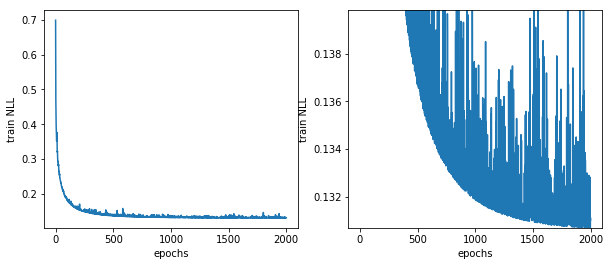

In [105]:

plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.plot(history)
ax.set_xlabel('epochs')
ax.set_ylabel('train NLL')

ax = plt.subplot(122)
ax.plot(history)
ax.set_xlabel('epochs')
ax.set_ylabel('train NLL')
ax.set_ylim(np.min(history), 0.2*np.max(history))